## Decimation exercise

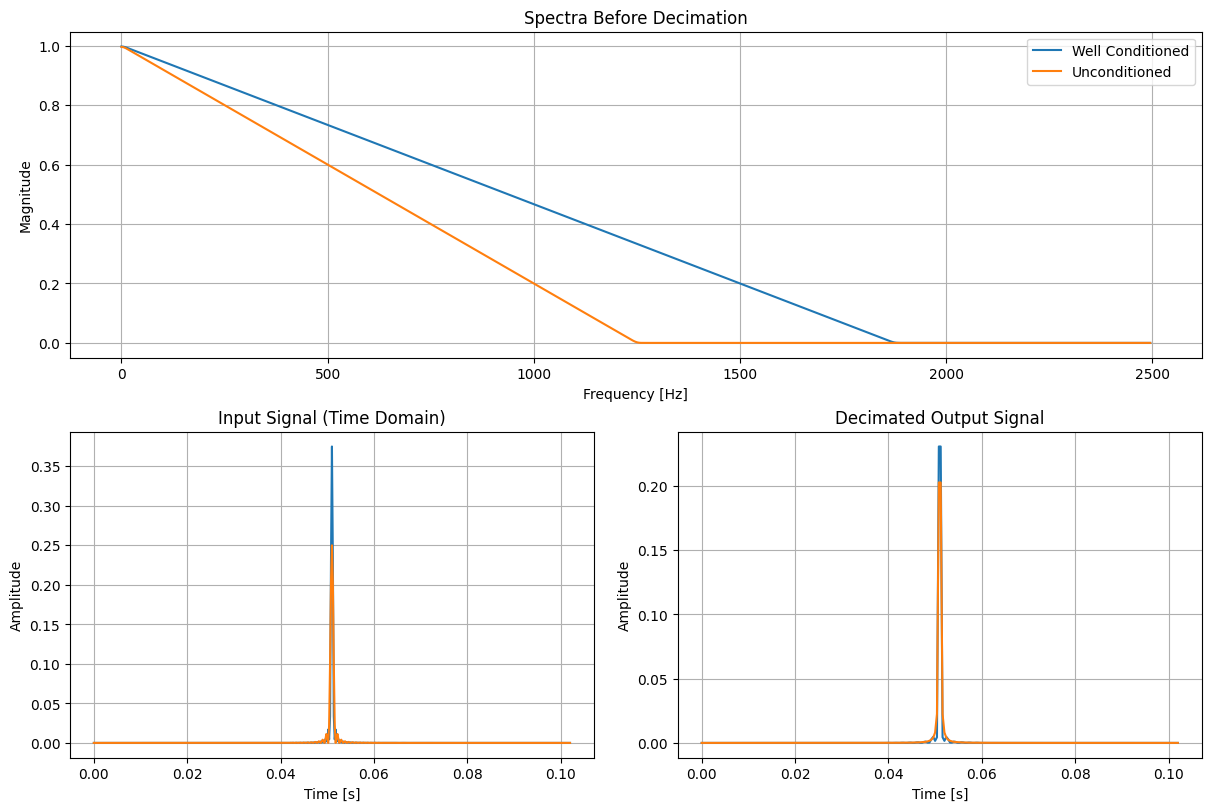

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg
import scipy.fft as sf


Nf = 512  # Number of frequency points
fs = 5000
t = np.arange(Nf - 1) / fs  # Matches firwin2(Nf - 1)

f = [0, 0.25, 0.5, 0.75, 1]
a1 = [1, 0.6667, 0.3333, 0, 0]
a2 = [1.0000, 0.5000, 0, 0, 0]

input_signal_1 = sg.firwin2(Nf - 1, f, a1)
input_signal_2 = sg.firwin2(Nf - 1, f, a2)


# Frequency response of original signals
w, H1 = sg.freqz(input_signal_1, 1, worN=Nf, fs=fs)
_, H2 = sg.freqz(input_signal_2, 1, worN=Nf, fs=fs)

# DECIMATION
P = 2  # Decimation factor
output_signal_1 = input_signal_1[::P]
output_signal_2 = input_signal_2[::P]
to = t[::P]  # decimated time vector

# Plot spectra and time-domain before/after decimation
fig = plt.figure(figsize=(12, 8), layout='constrained')
axs = fig.subplot_mosaic([['spectrum', 'spectrum'], ['input', 'output']])

axs['spectrum'].set_title("Spectra Before Decimation")
axs['spectrum'].plot(w, np.abs(H1), label="Well Conditioned", color='C0')
axs['spectrum'].plot(w, np.abs(H2), label="Unconditioned", color='C1')
axs['spectrum'].set_xlabel("Frequency [Hz]")
axs['spectrum'].set_ylabel("Magnitude")
axs['spectrum'].legend()
axs['spectrum'].grid(True)

axs['input'].set_title("Input Signal (Time Domain)")
axs['input'].plot(t, input_signal_1, label="Well", color='C0')
axs['input'].plot(t, input_signal_2, label="Unconditioned", color='C1')
axs['input'].set_xlabel("Time [s]")
axs['input'].set_ylabel("Amplitude")
axs['input'].grid(True)

axs['output'].set_title("Decimated Output Signal")
axs['output'].plot(to, output_signal_1, label="Well ↓2", color='C0')
axs['output'].plot(to, output_signal_2, label="Unconditioned ↓2", color='C1')
axs['output'].set_xlabel("Time [s]")
axs['output'].set_ylabel("Amplitude")
axs['output'].grid(True)

plt.show()


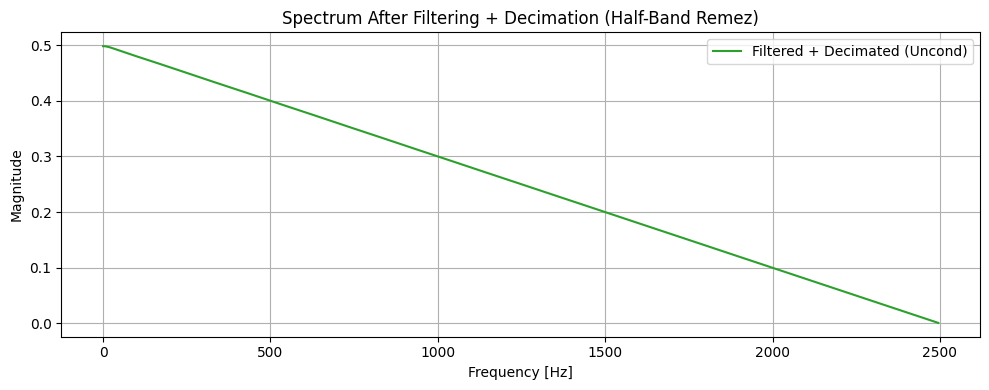

In [7]:
# Half-band FIR filter via Remez
numtaps = 101
cutoff = fs / 4         # 1250 Hz
transition = 200        # 200 Hz transition width

bands = [0, cutoff, cutoff + transition, fs / 2]
desired = [1, 0]
weights = [1, 1]

halfband_filter = sg.remez(numtaps, bands, desired, weight=weights, fs=fs)
# Filter and decimate unconditioned signal
filtered_uncond = sg.lfilter(halfband_filter, 1.0, input_signal_2)
output_filtered = filtered_uncond[::P]

# Plot spectrum
w, Hfilt = sg.freqz(output_filtered, 1, worN=Nf, fs=fs)

plt.figure(figsize=(10, 4))
plt.plot(w, np.abs(Hfilt), label="Filtered + Decimated (Uncond)", color='C2')
plt.title("Spectrum After Filtering + Decimation (Half-Band Remez)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

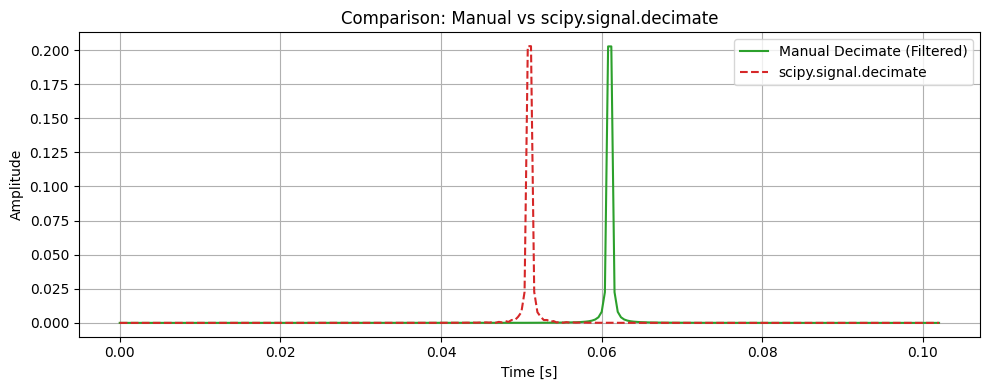

In [8]:
from scipy.signal import decimate

output_decimate = decimate(input_signal_2, P, ftype='fir')

# Plot comparison
plt.figure(figsize=(10, 4))
plt.plot(to, output_filtered[:len(to)], label="Manual Decimate (Filtered)", color='C2')
plt.plot(to[:len(output_decimate)], output_decimate, label="scipy.signal.decimate", linestyle='--', color='C3')
plt.title("Comparison: Manual vs scipy.signal.decimate")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Interpolation exercise

In [ ]:
f = [0, 0.25, 0.5, 0.75, 1]
a = [1.0, 0.5, 0, 0, 0]

Nf = 512
Q = 2
input_signal = sg.firwin2(Nf - 1, f, a)
w, H1 = sg.freqz(input_signal, 1, worN=Nf, whole=True)

f = np.linspace(-1, 1, Nf)

output_signal = np.zeros((len(input_signal) * Q, ))
for i in range(len(input_signal)):
    output_signal[i * Q] = input_signal[i]

w, H2 = sg.freqz(output_signal, 1, worN=Nf, whole=True)